## EXERCISE 3

### Part 1: Get Image Annotations from XML files
The dataset found in https://www.kaggle.com/andrewmvd/face-mask-detection contains two folders. The one includes '.png' images of isolated people or public crowds and the other includes information in the form of '.xml' files. The first thing to do is to get the annotations from the xml files and create a pandas dataframe to work with.

> Note: _I used the code from https://www.kaggle.com/stpeteishii/face-mask-get-annotation-info-from-xml_

#### Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
import glob
import xml.etree.ElementTree as ET

In [2]:
path_anno = "C:/Users/aggel/Documents/DataSets/archive/annotations"

In [3]:
dataset = {
        "xmin":[],
        "ymin":[],
        "xmax":[],
        "ymax":[],
        "name":[],
        "file":[],
        "width":[],
        "height":[],
        }

for anno in glob.glob(path_anno + "/*.xml"):
    tree = ET.parse(anno)
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag:
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))
        if 'object' in elem.tag:
            for attr in list(elem):
                if 'name' in attr.tag:
                    name = attr.text
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height]
                    dataset['file']+=[anno.split('/')[-1][12:-4]]
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

#### Create and view Dataframe
The dataframe contains information for every person that appears in each image. More specifically it contains the portion of the image that the person holds (in pixels) as well as the person's class. A person belongs in one of the following three classes : 'with_mask', 'mask_weared_incorrect' and 'without_mask'.

In [4]:
data = pd.DataFrame(dataset)
data

,xmin,ymin,xmax,ymax,name,file,width,height
0,79,105,109,142,without_mask,maksssksksss0,512,366
1,185,100,226,144,with_mask,maksssksksss0,512,366
2,325,90,360,141,without_mask,maksssksksss0,512,366
3,321,34,354,69,with_mask,maksssksksss1,400,156
4,224,38,261,73,with_mask,maksssksksss1,400,156
...,...,...,...,...,...,...,...,...
4067,263,62,287,85,with_mask,maksssksksss98,400,267
4068,344,80,377,106,with_mask,maksssksksss98,400,267
4069,181,54,273,162,mask_weared_incorrect,maksssksksss99,400,267
4070,99,87,176,165,with_mask,maksssksksss99,400,267


#### Convert data to .csv file and then load it to a variable called "annotations"

In [5]:
data.to_csv('annotation.csv', index=False)
annotations = pd.read_csv('annotation.csv')

#### Render a random image from the dataset

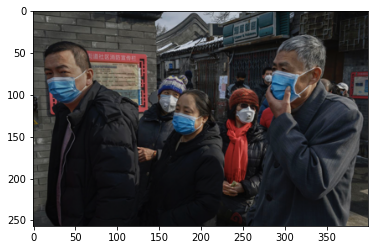

In [9]:
pathExample = 'C:/Users/aggel/Documents/DataSets/archive/images/maksssksksss214.png'
image=cv2.imread(pathExample)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

#### View the annotations for this image
We see that the image contains annotations (facial pixel portions and labels) for 7 people

In [12]:
anno = annotations[annotations['file']=='maksssksksss214']
anno

,xmin,ymin,xmax,ymax,name,file,width,height
526,14,61,61,110,with_mask,maksssksksss214,400,257
527,151,96,176,121,with_mask,maksssksksss214,400,257
528,166,110,199,149,with_mask,maksssksksss214,400,257
529,241,109,266,135,with_mask,maksssksksss214,400,257
530,286,58,331,112,with_mask,maksssksksss214,400,257
531,277,75,288,87,with_mask,maksssksksss214,400,257
532,244,82,254,91,with_mask,maksssksksss214,400,257


#### Extract annotation of each person and render an individual 60x60x3  rgb image

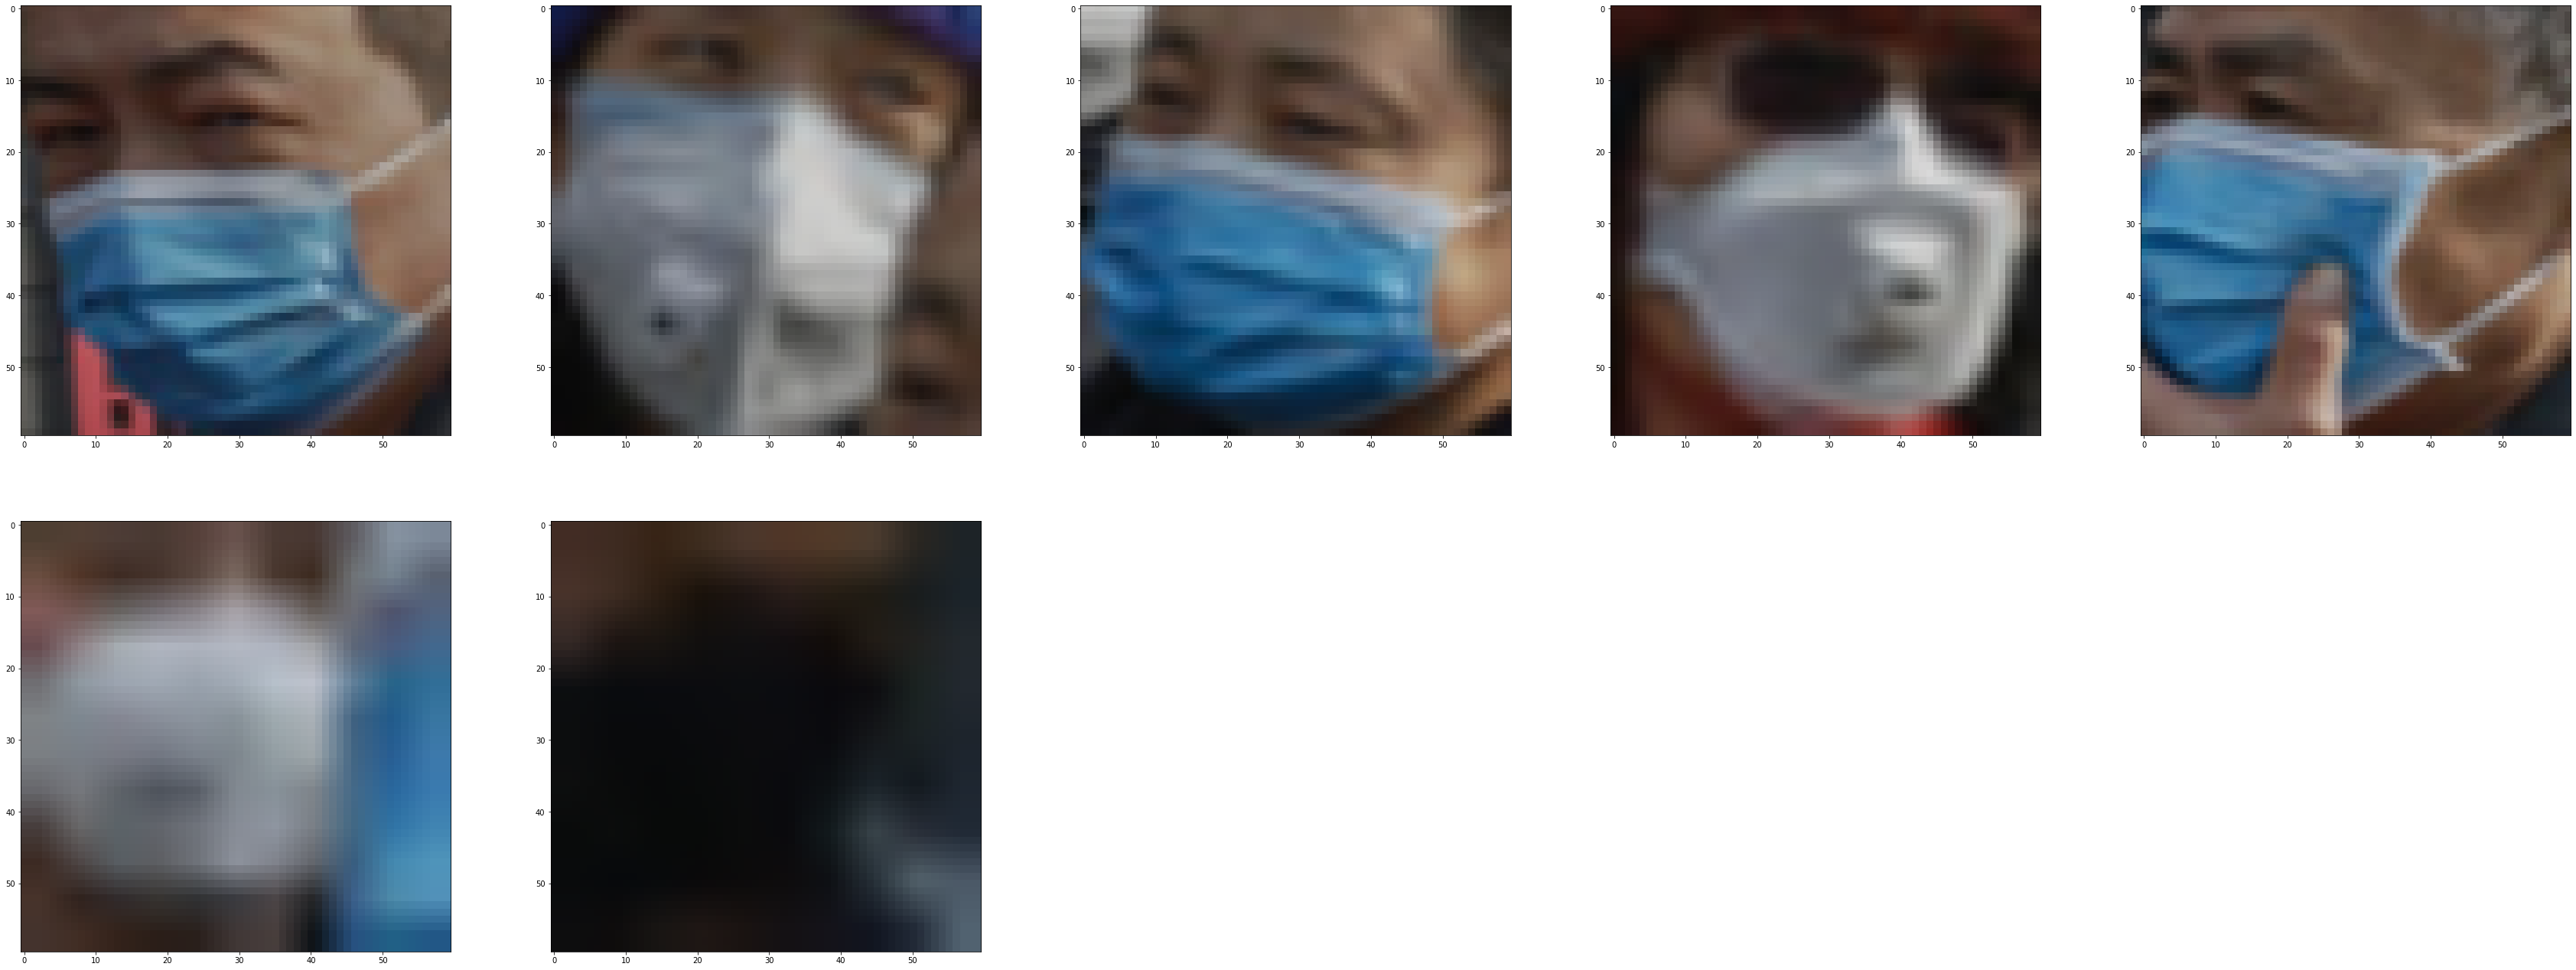

In [13]:
# list to store annotations of each person that appears in image
peopleDims = []
length = len(anno.values.tolist())
for i in range(length):
    personDims = anno.iloc[i:i+1,0:4].values.tolist()[0]
    peopleDims.append(personDims)

# list to store image of every person 
peopleImages = []
for personDims in peopleDims:
    xmin, ymin, xmax, ymax = personDims
    im = image[ymin:ymax, xmin:xmax]
    imResize = cv2.resize(im,(60,60))
    peopleImages.append(imResize)

plt.figure(figsize=(60,60))
for i in range(len(peopleImages)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(cv2.cvtColor(peopleImages[i], cv2.COLOR_BGR2RGB))


### Part 2: Set up a dataset that contains facial images of each person that appears in every image, alongside that person's class (label)

In [14]:
directory = 'C:/Users/aggel/Documents/DataSets/archive/images'

In [15]:
# list to store facial images
dataset=[]
# list to store labels of facial images
datalabel = []

# encode the labels 
normal_mapping={'with_mask':0, 'mask_weared_incorrect':1, 
                   'without_mask':2}

for file in tqdm(annotations['file'].unique()):
    path=os.path.join(directory,file+'.png')
    image=cv2.imread(path)
    anno=annotations[annotations['file']==file]
    length = len(anno.values.tolist())
    for i in range(length):
        [xmin,ymin,xmax,ymax]=anno.iloc[i:i+1,0:4].values.tolist()[0]
        label = anno.iloc[i:i+1]['name'].map(normal_mapping).values.tolist()[0]
        h=ymax-ymin
        w=xmax-xmin
        im=image[ymin:ymax,xmin:xmax]
        # keep only facial images with at least (10x10) resolution
        if im.shape[0]>=10 and im.shape[1]>=10:
            img=cv2.resize(im,(60,60))
            dataset+=[img]
            datalabel+=[label]

100%|████████████████████████████████████████████████████████████████████████████████| 853/853 [00:12<00:00, 70.78it/s]


#### Store data in numpy array form

In [16]:
dataSet = np.array(dataset)
dataLabel = np.array(datalabel)
print('The dataset contains : ', len(dataSet), ' images')

The dataset contains :  3603  images


#### Split the dataset to training and test set (80 - 20) and normalize data

In [17]:
from sklearn.model_selection import train_test_split

# we use stratify in order to roughly keep the same amount of class mebers in each set
x_train, x_test, y_train, y_test = train_test_split(
                                            dataSet, 
                                            dataLabel, 
                                            test_size = 0.2, 
                                            shuffle = True, 
                                            stratify = dataLabel)

#normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# vectorize the labels
y_train = to_categorical(y_train) # [1.,0.,0.] = 'with_mask' , [0.,1.,0.] = 'mask_weared_incorrect', [0.,0.,1.] = 'without_mask'
y_test = to_categorical(y_test)

print(len(x_train))
print(len(x_test))

2882
721


### Part 3: Build the CNN model
Our dataset is small (2882 images) so we will build a composite model that consists of a pretrained keras application cnn architecture and 2 dense layers (+output layer). The cnn model we chose is VGG16. We deactivate the fully connected top layers of the VGG16 so that it can work as a feature extractor. We feed the training images to the VGG16 and then pass its output features to two fully connected layers and finally a dense output layer with 3 nodes (one for each class).
> Note: We use ImageDataGenerator to augment the training dataset. We also introduce regularization in the dense layers in order to avoid overfitting. For training we use two callbacks to introduce adaptive learning. One is a step decay function which degrades the learning rate by half every 5 epochs and the other is an early stop callback that monitors validation accuracy. The last callback stops the training if the validation doesn't increase for 4 epochs since this implies that the model has stopped learning new features.

In [23]:
from keras import models as m
from keras import layers as l
from keras import regularizers as r
from keras.applications.vgg16 import VGG16

pretrainedModel = VGG16(
                    include_top = False, 
                    weights = 'imagenet',
                    input_shape = (60,60,3),
                    pooling = 'max')
pretrainedModel.trainable = False

model = m.Sequential()

model.add(pretrainedModel)

model.add(l.Flatten())

model.add(l.Dense(512, kernel_regularizer = r.l1(0.000001), bias_regularizer = r.l2(0.0001)))
model.add(l.BatchNormalization())
model.add(l.LeakyReLU(alpha=0.2))

model.add(l.Dense(256, kernel_regularizer = r.l1(0.00001), bias_regularizer = r.l2(0.0001)))
model.add(l.BatchNormalization())
model.add(l.LeakyReLU(alpha=0.2))

#model.add(l.GaussianNoise(0.2))
model.add(l.Dense(3, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                      

#### Compile the CNN model

In [24]:
model.compile(
            loss = 'categorical_crossentropy',
            optimizer = tf.optimizers.Adam(),
            metrics = ['accuracy'])


#### Callbacks

In [25]:
import math

# learning rate step decay function
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate*math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 4)
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

callback_list = [earlyStop, lrate]

#### Create augmented data images

In [26]:
datagen = ImageDataGenerator(
            rotation_range = 15,
            width_shift_range = 0.2,
            height_shift_range = 0.1,
            zoom_range = 0.1,
            brightness_range=[0.2,1],
            horizontal_flip = True)

#### Train the model

In [28]:
history = model.fit(
                datagen.flow(x_train, y_train, batch_size = 16),
                epochs = 25, callbacks = [callback_list],
                validation_data = (x_test, y_test), shuffle = True,
                verbose = 1)

Epoch 1/25
181/181 [==============================] - 29s 155ms/step - loss: 0.5336 - accuracy: 0.8442 - val_loss: 0.6362 - val_accuracy: 0.7989 - lr: 0.0010
Epoch 2/25
181/181 [==============================] - 28s 156ms/step - loss: 0.3916 - accuracy: 0.8900 - val_loss: 0.7805 - val_accuracy: 0.8003 - lr: 0.0010
Epoch 3/25
181/181 [==============================] - 29s 158ms/step - loss: 0.3823 - accuracy: 0.8928 - val_loss: 0.9610 - val_accuracy: 0.3135 - lr: 0.0010
Epoch 4/25
181/181 [==============================] - 33s 180ms/step - loss: 0.3510 - accuracy: 0.9032 - val_loss: 0.6168 - val_accuracy: 0.7989 - lr: 0.0010
Epoch 5/25
181/181 [==============================] - 34s 189ms/step - loss: 0.3383 - accuracy: 0.9032 - val_loss: 0.6047 - val_accuracy: 0.7989 - lr: 5.0000e-04
Epoch 6/25
181/181 [==============================] - 30s 167ms/step - loss: 0.3069 - accuracy: 0.9122 - val_loss: 0.6190 - val_accuracy: 0.7989 - lr: 5.0000e-04


> Note: Training stopped after 6 epochs

#### Test score of model on  test  set

In [35]:
datagen = ImageDataGenerator(
            rotation_range = 30,
            width_shift_range = 0.2,
            height_shift_range = 0.1,
            zoom_range = 0.1,
            brightness_range=[0.2,1],
            horizontal_flip = True,
            fill_mode = 'nearest')

test_results = model.evaluate(x_test,y_test,batch_size=1)
aug_test_results = model.evaluate(datagen.flow(x_test,y_test,batch_size=1))

721/721 [==============================] - 12s 16ms/step - loss: 0.3438 - accuracy: 0.9168


#### Prediction Function

In [39]:
def predict(x,y, predictor):
    # Get the data from the test set
    # Get output of network and prediction
    activations = predictor.predict(x.reshape(1, 60, 60, 3))
    prediction = np.argmax(activations)
    # Print the prediction of the network
    print('Network output: ')
    print(activations)
    print('Network prediction: ')
    print(prediction)
    print('Actual image: ')
    print('image_label', np.argmax(y))
    # Draw the image
    #plt.bar(range(10), activations[0])
    #plt.show()
    plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
    #plt.imshow(x)
    plt.show()

Network output: 
[[0.8028808  0.01205371 0.18506548]]
Network prediction: 
0
Actual image: 
image_label 0


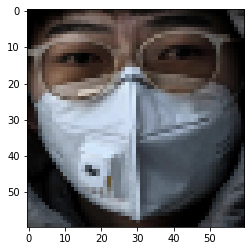

In [38]:
predict(x_test[221],y_test[221], model)

#### Save Model

In [47]:
model.save("exercise3Model.h5")

#### Load Model and check that it is saved

In [48]:
loaded_model = tf.keras.models.load_model("exercise3Model.h5")

Network output: 
[[0.8028808  0.01205371 0.18506548]]
Network prediction: 
0
Actual image: 
image_label 0


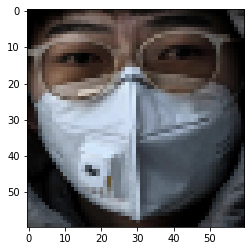

In [52]:
predict(x_test[221],y_test[221], loaded_model)